# Code to pull terminus positions from the manual delineations exported from GEEDiT

_By Jukes Liu. last modified 11-10-2019._

## Set up:

In [8]:
import pandas as pd
import numpy as np
import os
import subprocess
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg
import matplotlib.pylab as pl
import numpy.ma as ma
import datetime
import math

#geospatial packages
import fiona
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
import shapely
#shapely to explore 2D spatial relationships (e.g. intersection of 2 vector files)

basepath = '/media/jukes/jukes1/Manual/'

In [9]:
#Read in glacier velocity data
flowspeed_df= pd.read_csv('/home/jukes/Documents/Sample_glaciers/Glacier_velocities.csv', sep=',', dtype=str, header=0, usecols=[1,2,3])
flowspeed_df = flowspeed_df.set_index('BoxID')

In [5]:
#define a function to calculate terminus change rate:
def calc_changerates(df):
    original_len = df.shape[0]
    terminus_changerates = []
    
    for i in range(0, len(df.index)):
        date = list(df['datetimes'])[i]
        term_position = list(df['term_position'])[i]
        
        #CALCULATE TERMINUS CHANGE RATE
        #grab the earliest date
        earliestdate = list(df['datetimes'])[0]
        #for the first date, the changerate is nan
        if date == earliestdate:
            changerate = np.NaN
        #for all other subsequent entries:
        else:
            #grab current date and terminus position
            t = date
            x = term_position
        
            #grab previous date of analysis 
            counter = 1
            t_prev = list(df['datetimes'])[i-counter]

            #while the previous date = current date, append the counter and find the previous previous date
            while t_prev == t:
                counter = counter+1
                t_prev = list(df['datetimes'])[i-counter]

            #grab all terminus positions from previous date of analysis:
            prev_df = df[df['datetimes'] == t_prev].copy()

#             #grab the one that corresponds to the highest order
#             highestorder = np.min(np.array(prev_df['Order']))
#             positions = list(prev_df[prev_df['Order']==highestorder].term_position)
            positions = list(prev_df['term_position'])
            
            #if there are multiple, grab the smallest
            if len(positions) > 1:
                x_prev = np.min(np.array(positions))
                #otherwise, just grab the one
            else:
                x_prev = float(list(positions)[0])

            #calculate terminus change (m)
            delta_x = x - x_prev
            #calculate time change (days)
            delta_t = t - t_prev
            delta_t = delta_t.days

            #Calculate change rate!
            changerate = delta_x/delta_t

        terminus_changerates.append(changerate)
        
    df['changerate'] = terminus_changerates
    return original_len, len(terminus_changerates)

In [6]:
def remove_dips(df, flow_thresh, iterations):
    for iteration in range(0, iterations):
        #reset index
        df = df.reset_index(drop=True)

        dip_indices = []

        # for index, row in onepick_df.iterrows():
        for index, row in df.iterrows():
            rate = row['changerate']
            date = row['datetimes']
            #for negative change rates:
            if rate < 0:
                #make the threshold negative
                flow_thresh = -flow_thresh
                #if it's unrealistic (faster than threshold)
                if rate < flow_thresh:
                    #check the next entry only if it's in the range of indices
                    if index+1 < len(df.index):  
                        counter = 1

                        #pick the next immediate rate/date
                        nextrate = df.loc[index+counter]['changerate']
                        nextdate = df.loc[index+counter]['datetimes']                    

                        #while the next date is the same as the current, increment the counter
                        #to grab the next next date until the next date is different from the current
                        while nextdate == date:
                            counter = counter + 1
                            nextrate = df.loc[index+counter]['changerate']
                            nextdate = df.loc[index+counter]['datetimes']

                        #if it's a sudden jump, then we have found a dip. Remove it
                        if nextrate > abs(flow_thresh):
                            dip_indices.append(index)
                            
                #if it's a crazy large negative change, remove it even if there isn't a positive change following
                if rate < -(10*abs(flow_thresh)):
                    dip_indices.append(index)
                    
        print(dip_indices)

        #drop those indices
        df = df.drop(dip_indices)

        #recalculate terminus changerates
        calc_changerates(df)
        
    return df

In [413]:
def remove_jumps(df, flow_thresh, iterations):
    for iteration in range(0, iterations):
        #reset index for final_images_df
        df = df.reset_index(drop=True)

        jump_indices = []

        for i in range(0, len(df.index)):
            date = list(df['datetimes'])[i]
            rate = list(df['changerate'])[i]
            tpos = list(df['term_position'])[i]
            index = list(df.index)[i]

            if rate > abs(flow_thresh):
                #remove it:
                jump_indices.append(index)

            #remove drops if they are due to first value for the season
            #grab previous date of analysis 
            counter = 1
            prev_date = list(df['datetimes'])[i-counter]
            #while the previous date = current date, append the counter and find the previous previous date
            while prev_date == date:
                counter = counter+1
                prev_date = list(df['datetimes'])[i-counter]

            delta_date = date - prev_date
            delta_date = delta_date.days

            #if the time gap is more than 2 months, and has a positive change rate
            #and the terminus position is more than 80% of the max,
            tpos_thresh = 0.8*np.max(np.array(df['term_position']))
            #remove it
            if delta_date > 60 and rate > 0:
                if tpos > tpos_thresh:
                    jump_indices.append(index)

        print(jump_indices)
        #drop the indices
        df = df.drop(jump_indices)

        #re_calculate terminus change rates
        calc_changerates(df)
        
    return df

## 1) Reproject manual delineation shapefiles into Greenland Polar Stereo and grab BoxIDs

Remove files that have (#) in them:

In [17]:
counter = 0
BoxIDs = []
for folder in os.listdir(basepath):
    files = os.listdir(basepath+folder)
    if '(' in file:
        #remove it
        os.remove(basepath+folder+file)
        #keep track of how many shapefiles there are
        counter = counter + 1
    print(folder[3:])
    BoxIDs.append(folder[3:])
print(counter)

001
277
0


In [14]:
# counter = 0
# BoxIDs = []

# for file in os.listdir(basepath):
#     if file.endswith('.shp'):
#         #pull BoxID from name of file
#         BoxID = '%03d' % int(file.split('_')[0][3:])

#         #reproject the file from lat, long to Greenland Polar Stereo
#         linepath = basepath+file[:-4]
#         rp_command = 'ogr2ogr -f "ESRI Shapefile" -t_srs EPSG:3413 -s_srs EPSG:4326 '+linepath+'_PS.shp '+linepath+'.shp'
# #         print(rp_command)
# #         subprocess.call(rp_command, shell=True)
        
#         #keep track of how many shapefiles there are
#         counter = counter + 1
        
#         BoxIDs.append(BoxID)
        
# print(counter)
# BoxIDs = list(set(BoxIDs))
# print(BoxIDs)

## 2) Rasterize the shapefiles and subset to the buffer zones

In [36]:
for file in os.listdir(basepath):
    if file.endswith('PS.shp'):
        #pull BoxID from name of file
        BoxID = '%03d' % int(file.split('_')[0][3:])
        
        linepath = basepath+file[:-4]
        buffer_path = "/home/jukes/Documents/Sample_glaciers/Box"+BoxID+"/Buffer"+BoxID+".shp"
        
        rasterize_cmd = 'gdal_rasterize -burn 1.0 -tr 15.0 15.0 -a_nodata 0.0 '+linepath+'.shp '+linepath+'.TIF'
#         print(rasterize_cmd)
        
        subsetbuffer_cmd = 'gdalwarp -cutline '+buffer_path+' -crop_to_cutline '+linepath+'.TIF'+" "+linepath+'_cut.TIF'
#         print(subsetbuffer_cmd)
        
#         subprocess.call(rasterize_cmd, shell=True)
#         subprocess.call(subsetbuffer_cmd, shell=True)
#         print(file+" done.")

## 2A) Rotate the rasterized delineations using rotations.ijm

Then, convert rotated, rasterized delineations to png files to read in:

In [549]:
# %%bash

# cd /media/jukes/jukes1/Manual/
# mogrify -format png *cut.TIF

## 3) Read in rotated and resized boxes to calculate midpoints and centerline

In [550]:
#create dictionary to store each terminus box ndarray by BoxID
termboxes = {}

#read in the terminus box rasters
for BoxID in BoxIDs:
    #load in the raster
    boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated/crop_manual/Box"+BoxID+"_raster_cut.png"
#     boxpath = "/media/jukes/jukes1/LS8aws/Box"+BoxID+"/resized/crop_R_Box"+BoxID+"_cut.pgm"
    #read the raster into an ndarray
    termbox = mpimg.imread(boxpath)
    #add the ndarray into a dictionary with the BoxID as the key
    termboxes.update( {BoxID: termbox} )

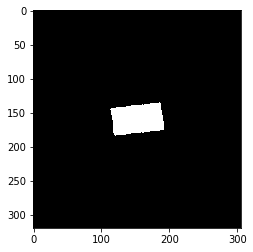

In [552]:
#visualize each terminus box rasters by BoxID
termplot = plt.imshow(termboxes['001'])
plt.show()

In [592]:
#create dictionary to store the all coordinates of the box rasters
boxes_xcoords = {}
boxes_ycoords = {}

#create dictionaries for the box vertices
topleft_coords = {}
bottomleft_coords = {}
topright_coords = {}
bottomright_coords = {}

#create dictionaries to store the left midpoints (1C) and right midpoints (2C)
midpoints_x = {}
midpoints_y = {}
midpoints_r_x = {}
midpoints_r_y = {}

#create dictionaries to the slopes and intercepts of the centerline equations
slopes = {}
intercepts = {}

#for all the box rasters
for BoxID in BoxIDs:
    #Read in the raster of the BoxID of interest
    BOI = termboxes[BoxID]
    
    #find the coordinates of where the pixel value is nonzero (where the box exists)
    yindices, xindices, rgb = np.where(BOI > 0)

    #add box coordinates to the dictionary
    boxes_ycoords.update( {BoxID: yindices})
    boxes_xcoords.update( {BoxID: xindices})
    
    
    #1A) FIND THE TOP LEFT COORDINATES (lowest x*y)
    xy = xindices*yindices
    #Find the lowest xy value
    min_xy = np.min(xy)
    #Find the x and y pair corresponding to that xy using the index
    min_xy_i = np.where(xy == min_xy)[0][0]
    topleft = [xindices[min_xy_i], yindices[min_xy_i]]
#     print("Top left", topleft)
    #Add to dictionary of topleft coordinates
    topleft_coords.update(  {BoxID: topleft}  )
    
    #2B) FIND THE BOTTOM RIGHT COORDINATES (highest x*y)
    max_xy = np.max(xy)
    max_xy_i = np.where(xy == max_xy)[0][0]
    bottomright = [xindices[max_xy_i], yindices[max_xy_i]]
    bottomright_coords.update( {BoxID: bottomright})

    #1B) FIND THE BOTTOM LEFT COORDINATE(highest y/x)
    y_x = yindices/xindices
    #Find the highest y/x value
    max_y_x = np.max(y_x)
    #Find the x and y pair corresponding to that y/x using the index
    max_y_x_i = np.where(y_x == max_y_x)[0][0]
    bottomleft = [xindices[max_y_x_i], yindices[max_y_x_i]]
#     print("Bottom left", bottomleft)
    #Add to dictionary of bottomleft coordinates
    bottomleft_coords.update( {BoxID: bottomleft}  )
    
    #2A) FIND THE TOP RIGHT COORDINATES (highest x/y)
    x_y = xindices/yindices
    #find highest x/y value:
    max_x_y = np.max(x_y)
    #Find the x, y pair correpsonding to the maximum x/y using the index
    max_x_y_i = np.where(x_y == max_x_y)[0][0]
    topright = [xindices[max_x_y_i], yindices[max_x_y_i]]
    topright_coords.update( {BoxID: topright} )
    
    #1C and 2C) CALCULATE THE MIDPOINTS
    #Left
    midpoint_x = (topleft[0]+bottomleft[0])/2
    midpoint_y = (topleft[1]+bottomleft[1])/2  
    #Right
    midpoint_r_x = (topright[0]+bottomright[0])/2
    midpoint_r_y = (topright[1]+bottomright[1])/2
    
    #midpoint = [midpoint_x, midpoint_y]
    #Add x and y coordinates to dictionaries
    midpoints_x.update( {BoxID: midpoint_x}  )
    midpoints_y.update( {BoxID: midpoint_y}  )
    midpoints_r_x.update( {BoxID: midpoint_r_x})
    midpoints_r_y.update( {BoxID: midpoint_r_y})
    
    #3) CALCULATE CENTERLINE EQUATION
    #slope
    m = (midpoint_r_y - midpoint_y)/(midpoint_r_x - midpoint_x)
    #y-intercept
    b = midpoint_y - (m*midpoint_x)
#     print("y =", m, "x +", b)
    
    #add slope and intercepts to dictionaries
    slopes.update( {BoxID: m})
    intercepts.update( {BoxID: b})

In [604]:
print(midpoint_y, midpoint_r_y)
# midpoint_y

208.0 203.5


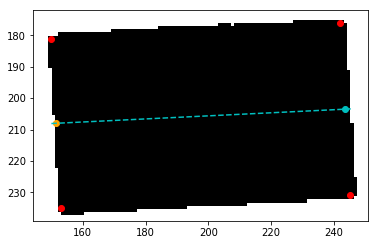

In [605]:
#Choose which glacier BoxID to check:
BOI_ID = '277'

#plot the raster pixels in black
plt.scatter(boxes_xcoords[BOI_ID], boxes_ycoords[BOI_ID], c='k',marker='s')

#plot the vertices in red
plt.scatter(topleft_coords[BOI_ID][0], topleft_coords[BOI_ID][1], c='r')
plt.scatter(bottomleft_coords[BOI_ID][0], bottomleft_coords[BOI_ID][1], c='r')
plt.scatter(topright_coords[BOI_ID][0], topright_coords[BOI_ID][1], c='r')
plt.scatter(bottomright_coords[BOI_ID][0], bottomright_coords[BOI_ID][1], c='r')

#plot midpoints in cyan
plt.scatter(midpoints_x[BOI_ID], midpoints_y[BOI_ID], c='orange')
plt.scatter(midpoints_r_x[BOI_ID], midpoints_r_y[BOI_ID], c='c')

#plot the centerlines in blue
x=np.linspace(np.min(boxes_xcoords[BOI_ID]), np.max(boxes_xcoords[BOI_ID]))
y=slopes[BOI_ID]*x + intercepts[BOI_ID]
plt.plot(x, y, '--c')
         
plt.gca().invert_yaxis()
plt.axis('scaled')
plt.show()

In [606]:
midpoints_x_df = pd.DataFrame.from_dict(midpoints_x, orient='index', columns=["midpoint_x"])
midpoints_y_df = pd.DataFrame.from_dict(midpoints_y, orient='index', columns=['midpoint_y'])

cline_slopes_df = pd.DataFrame.from_dict(slopes, orient='index', columns=["cline_slope"])
cline_intercepts_df = pd.DataFrame.from_dict(intercepts, orient='index', columns=["cline_intercept"])

centerline_df = pd.concat([midpoints_x_df, midpoints_y_df, 
                           cline_slopes_df, cline_intercepts_df], axis=1)
centerline_df.index.name = 'BoxID'
centerline_df

,midpoint_x,midpoint_y,cline_slope,cline_intercept
BoxID,,,,
001,117.0,163.5,-0.118881,177.409091
277,151.5,208.0,-0.048913,215.410326


## 4) Read in rasterized delineations and grab pixel coordinates

In [19]:
IDs = []
line_xs = []
line_ys = []
dates = []
for BoxID in BoxIDs:
    for file in os.listdir(basepath+'Box'+BoxID+'/rotated/'):
        if file.endswith('PS_cut.png'):
            #pull date from name of file
            date = file.split('_')[4][:10]

            linepath = basepath+'Box'+BoxID+'/rotated/'+file
            line = mpimg.imread(linepath)
            y, x, rgb = np.where(line > 0)
            
            line_x = []
            line_y = []
            for i in range(0, len(y)):
                x0 = x[i]
                y0 = y[i]
                rgb0 = rgb[i]
  
                if rgb0 == 0:
#                     print(x0, y0, rgb0)
                    line_x.append(x0)
                    line_y.append(y0)

            IDs.append(BoxID)
            dates.append(date)
                    
            line_xs.append(line_x)
            line_ys.append(line_y)

manual_df = pd.DataFrame(list(zip(IDs, dates, line_xs, line_ys)),
              columns=['BoxID','datetimes', 'Line_x', "Line_y"])
manual_df = manual_df.sort_values(by=['BoxID', 'datetimes'])

## Manual delineations gif Box001

In [20]:
#Turn datetimes from datetime_df into DateTime objects
#grab the datetime strings
datetimes = manual_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
manual_df['datetimes'] = datetime_objs

In [22]:
manual_df.to_csv(path_or_buf = basepath+"Manual_imgdates.csv", sep=',')

In [21]:
manual_df

,BoxID,datetimes,Line_x,Line_y
190,001,1987-10-14,"[153, 153, 151, 152, 150, 151, 149, 148, 146, ...","[132, 133, 134, 134, 135, 135, 136, 138, 139, ..."
126,001,1995-04-13,"[152, 153, 153, 153, 153, 153, 154, 154, 155, ...","[135, 136, 137, 138, 139, 140, 141, 142, 142, ..."
57,001,1995-05-31,"[153, 153, 153, 153, 153, 154, 154, 157, 158, ...","[137, 138, 139, 140, 142, 143, 145, 145, 145, ..."
9,001,2013-05-25,"[131, 131, 132, 133, 134, 134, 135, 136, 136, ...","[141, 143, 144, 144, 145, 146, 146, 146, 147, ..."
238,001,2013-05-29,"[130, 131, 130, 131, 131, 132, 134, 134, 135, ...","[142, 142, 144, 144, 145, 146, 147, 148, 148, ..."
247,001,2013-06-01,"[131, 131, 131, 131, 133, 134, 136, 137, 138, ...","[142, 143, 144, 145, 146, 147, 148, 149, 149, ..."
172,001,2016-03-18,"[125, 127, 128, 129, 130, 131, 132, 133, 134, ...","[147, 147, 148, 148, 149, 149, 149, 149, 149, ..."
205,001,2016-03-21,"[126, 127, 128, 129, 130, 133, 134, 135, 136, ...","[146, 146, 146, 147, 147, 148, 149, 149, 150, ..."
195,001,2016-03-22,"[128, 129, 130, 131, 132, 134, 135, 136, 137, ...","[147, 147, 147, 148, 148, 149, 149, 149, 150, ..."
44,001,2016-03-24,"[131, 133, 133, 134, 135, 136, 137, 137, 138, ...","[147, 147, 148, 148, 148, 148, 149, 150, 151, ..."


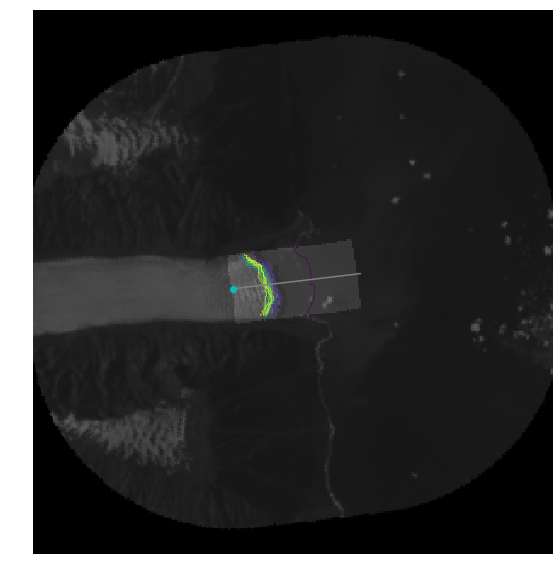

In [687]:
#PLOT THE LANDSAT IMAGE and TERMINUS BOX
BoxID = '001'
box_df = manual_df[manual_df.BoxID == BoxID].copy()
# box_df = box_df[box_df.Date > np.datetime64('2013-01-01')].copy()

#Read in the non_rotated subset image:
# image = mpimg.imread('/media/jukes/jukes1/LS8aws/Box'+BoxID+'/rotated/crop_manual/R_LC80310052014178LGN00_B8_PS_Buffer'+BoxID+'.png')
tbox = mpimg.imread("/media/jukes/jukes1/LS8aws/Box"+BoxID+"/rotated/crop_manual/Box"+BoxID+"_raster_cut.png")

plt.figure(figsize=(20,10))
plt.axis("off")
imgplt_trim = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
boxplt = plt.imshow(tbox, alpha=0.1)

counter = 0
for idx, row in box_df.iterrows():
    if idx % 7 == 0:
        counter = counter + 1
        
colors = pl.cm.viridis(np.linspace(0,1,counter))

col_count = 0
for idx, row in box_df.iterrows():
    if idx % 7 == 0:
        #     BoxID = idx
        line_x = row['Line_x']
        line_y = row['Line_y']

        plt.plot(line_x, line_y, color=colors[col_count], linewidth=0.5)
        col_count = col_count+1
        
#grab x-values from height of terminus box
c_slope = float(centerline_df.loc[BoxID]['cline_slope'])
c_intercept = float(centerline_df.loc[BoxID]['cline_intercept'])
xmin = float(centerline_df.loc[BoxID]['midpoint_x'])
xmax = np.max(np.array(list(set(np.nonzero(tbox)[1]))))

c_x = np.linspace(xmin, xmax, int(xmax-xmin)*2)
c_y = c_slope*c_x + c_intercept
plt.plot(c_x, c_y, color='gray')
plt.plot(c_x[0], c_y[0], 'co')

plt.show()


## 5) Calculate interesections with centerline and terminus position

In [688]:
#define a function to help us find the intersection of a line and a collection of points:
#determines if an input value is within a certain range/interval or a setvalue:
def within(value, setval, interval):
    if value >= setval-interval and value <= setval+interval:
        return True
    else:
        return False

In [689]:
def distance(x1, y1, x2, y2):
    dist = math.sqrt(((x2-x1)**2)+((y2-y1)**2))
    return dist

In [690]:
intersection_x = []
intersection_y = []
term_pos = []

counter = 0

for idx, row in manual_df.iterrows():
    BoxID = row['BoxID']
    line_x = row['Line_x']
    line_y = row['Line_y']
    
    #grab slope and intercept from the dataframe
    c_slope = float(centerline_df.loc[BoxID]['cline_slope'])
    c_intercept = float(centerline_df.loc[BoxID]['cline_intercept'])
    
    #grab x-values from height of terminus box
    ymid = float(centerline_df.loc[BoxID]['midpoint_y'])
    xmid = float(centerline_df.loc[BoxID]['midpoint_x'])
    xmax = np.max(np.array(list(set(np.nonzero(tbox)[1]))))
    c_x = np.linspace(xmid, xmax, int(xmax-xmid)*2)
    c_y = c_slope*c_x + c_intercept
    
    #FIND Intersections   
    intersect_xs = []
    intersect_ys = []
    
    #loop through all the x,y values for the centerline
    for j in range(0, len(c_x)):
        x = c_x[j]
        y = c_y[j]
        interval = 0.7
        #where are the intersections with the terminus pick?
        for i in range(0, len(line_x)):
            lx = line_x[i]
            ly = line_y[i]
            if within(lx, x, interval) and within (ly, y, interval):
                intersect_xs.append(lx)
                intersect_ys.append(ly)
    
    if len(intersect_xs) != 0 or len(intersect_ys) != 0:
        intersect_x = intersect_xs[0]
        intersect_y = intersect_ys[0]
    
#         print(intersect_x, intersect_y)
        intersection_x.append(intersect_x)
        intersection_y.append(intersect_y)
        
        #calculate terminus position using distance formula
#         term_position = intersect_y - np.min(c_y)
        term_position = distance(xmid, ymid, intersect_x, intersect_y)
        
        term_pos.append(term_position*15.0)
    else:
        intersection_x.append(np.nan)
        intersection_y.append(np.nan)
        term_pos.append(np.nan)
        
        counter = counter + 1
        
manual_df['intersect_x'] = intersection_x
manual_df['intersect_y'] = intersection_y
manual_df['term_position'] = term_pos

In [647]:
#Turn datetimes from datetime_df into DateTime objects
#grab the datetime strings
datetimes = manual_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
manual_df['datetimes'] = datetime_objs

ValueError: unconverted data remains:  00:00:00

## 6) Plot terminus position and terminus changerate timeseries

In [753]:
BOI = '277'
df = manual_df[manual_df['BoxID']==BOI].copy()

#calculate terminus change rate
calc_changerates(df)
df

,BoxID,datetimes,Line_x,Line_y,intersect_x,intersect_y,term_position,changerate
475,277,1985-03-30,"[233, 233, 234, 235, 235, 236, 237, 238, 238, ...","[194, 195, 198, 201, 203, 206, 208, 209, 210, ...",NaN,NaN,NaN,NaN
508,277,1985-06-02,"[223, 223, 224, 224, 225, 225, 226, 227, 227, ...","[175, 176, 178, 179, 179, 180, 182, 185, 186, ...",NaN,NaN,NaN,NaN
412,277,1985-07-27,"[214, 215, 216, 217, 217, 218, 219, 220, 221, ...","[184, 185, 185, 186, 187, 187, 188, 188, 191, ...",NaN,NaN,NaN,NaN
517,277,1985-08-12,"[212, 213, 214, 215, 216, 217, 218, 219, 220, ...","[182, 184, 184, 186, 186, 188, 188, 189, 190, ...",NaN,NaN,NaN,NaN
549,277,1985-08-14,"[220, 221, 222, 223, 224, 225, 226, 227, 227, ...","[189, 190, 190, 192, 192, 193, 193, 195, 196, ...",NaN,NaN,NaN,NaN
377,277,1985-09-06,"[207, 208, 209, 209, 210, 211, 212, 212, 213, ...","[168, 169, 170, 171, 171, 173, 174, 175, 177, ...",NaN,NaN,NaN,NaN
433,277,1986-05-04,"[215, 216, 216, 217, 218, 219, 219, 220, 221, ...","[177, 177, 178, 179, 181, 181, 182, 183, 184, ...",NaN,NaN,NaN,NaN
536,277,1986-07-30,"[215, 216, 217, 218, 219, 219, 220, 221, 221, ...","[194, 194, 197, 198, 200, 201, 201, 203, 204, ...",NaN,NaN,NaN,NaN
572,277,1986-08-17,"[218, 219, 220, 221, 222, 222, 223, 224, 225, ...","[187, 188, 189, 191, 191, 192, 193, 196, 197, ...",NaN,NaN,NaN,NaN
276,277,1986-09-18,"[214, 215, 216, 217, 218, 219, 220, 220, 220, ...","[178, 178, 179, 180, 181, 181, 183, 184, 185, ...",NaN,NaN,NaN,NaN


In [692]:
#Grab max flow threshold from glacier velocities in flowspeed_df
max_flow = float(flowspeed_df['Max_speed'][BOI])
if max_flow < 1.0:
    flow_thresh = 5.0
else:
    flow_thresh = 5.0*max_flow
print(flow_thresh)

5.0


Filtering:

In [542]:
#REMOVE DIPS ITERATIVELY n=5 times
nodips = remove_dips(df, flow_thresh, 6)

[11, 13, 21, 23, 25, 27, 33, 51, 114, 116, 123, 165, 193, 215, 222, 245, 252]
[13, 178]
[39, 132]
[]
[]
[]


In [543]:
#REMOVE JUMPS ITERATIVELY
nojumps = remove_jumps(nodips, flow_thresh, 3)

[25, 33, 66, 71, 77, 86, 105, 126, 140, 149, 153, 158, 162, 172, 182, 196, 203, 211, 216, 220, 231]
[68, 81, 119, 143, 150, 159, 187, 201]
[68]


In [544]:
df = nojumps

## PLOT TIMESERIES

In [754]:
#Read in automated df
auto_df = pd.read_csv('/home/jukes/Documents/Sample_glaciers/Tpos_timeseries_Box'+BOI+'_filtered.csv', sep=',')

#Turn datetimes from datetime_df into DateTime objects
#grab the datetime strings
datetimes = auto_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
auto_df['datetimes'] = datetime_objs

In [755]:
#grab max and min dates from automated time series:
maxdate = np.max(list(auto_df['datetimes']))
mindate = np.min(list(auto_df['datetimes']))

#grab only manual delineations between those dates
df_2013 = df[df['datetimes'] > mindate].copy()
ls8_df = df_2013[df_2013['datetimes'] < maxdate].copy()

In [749]:
new_tpos = []

for idx, row in auto_df.iterrows():
    if row['term_position'] > 400.0:
        new_tpos.append(np.nan)
    else:
        new_tpos.append(row['term_position'])

In [750]:
auto_df['term_position'] = new_tpos

In [760]:
#drop nans
ls8_df = ls8_df.dropna()
auto_df = auto_df.dropna()

# #grab max terminus position across both
max_tpos_man = np.max(list(ls8_df['term_position']))+45#+(2*15.0)
max_tpos_auto = np.max(list(auto_df['term_position']))
# max_tpos_man = 0
# max_tpos_auto = 0
print(max_tpos_man, max_tpos_auto)

653.2402896882119 833.7153291142007


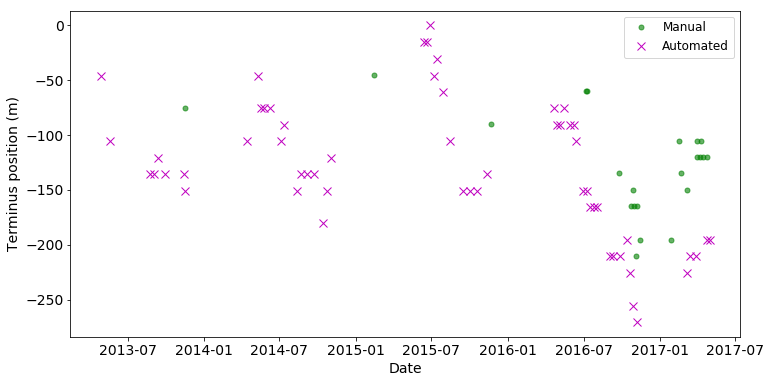

In [761]:
fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(ls8_df['datetimes'], np.array(ls8_df['term_position']) - max_tpos_man, 'go', markersize='5', alpha=0.6)

ax1.set_ylabel('Terminus position (m)', color='k', fontsize=14)


#Automated time series
# ax2 = ax1.twinx()
# ax2.plot(auto_df['datetimes'], np.array(auto_df['term_position']) - max_tpos_auto, 'mx', markersize='8', alpha=1)
ax1.plot(auto_df['datetimes'], np.array(auto_df['term_position']) - max_tpos_auto, 'mx', markersize='8', alpha=1)
# ax2.set_ylabel('Auto terminus position (m)', color = 'k', fontsize=12)
# ax2.get_yaxis().set_visible(False) 

#GENERAL PLOT PARAMETERS
# ax1.set_title("Box"+BOI, fontsize=16)
ax1.set_xlabel('Date', fontsize=14)
# ax1.set_ylim(-275, 25)
# ax2.set_ylim(-255, 10)
ax1.tick_params(axis='both', which='major', labelsize=14)
# ax2.tick_params(axis='both', which='major', labelsize=12)
fig.legend(['Manual', 'Automated'], bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes, fontsize=12)

#SAVE FIGURE
plt.savefig("/home/jukes/Documents/Sample_glaciers/Figures/Manual_vs_automated_Box"+BOI+".png", dpi=500)
plt.show()

In [742]:
comparison_df = pd.merge(auto_df.drop(['BoxID', 'Image_array', 'Dat_filename', 'Trimmed_dat_filename', 'Scale', 'Metric', 'Order'], axis=1), ls8_df.drop(['Line_x', 'Line_y', 'BoxID'], axis=1), how='inner', on='datetimes')

In [669]:
# comparison_df = comparison_df.drop(['Dat_filename', 'Trimmed_dat_filename', 'Scale', 'Order'], axis=1)

In [743]:
#recalculate terminus position for either side
comparison_df['term_position_x'] = np.array(comparison_df['term_position_x']) - max_tpos_auto
comparison_df['term_position_y'] = np.array(comparison_df['term_position_y']) - max_tpos_man

In [744]:
comparison_df['auto_man_diff'] = np.array(comparison_df['term_position_x']) - np.array(comparison_df['term_position_y'])

In [745]:
differences = np.array(comparison_df.auto_man_diff)

print(np.max(abs(differences)))
print(np.average(abs(differences)))

75.60344920765658
25.08822886337908


_Remnant code: shapely lines_

In [ ]:
## TURN SHP INTO LINESTRING IN SHAPELY
#         #grab coordinates and put into a line
#         manual = fiona.open(basepath+file)
# #         m = manual.next()
#         coordinates = m['geometry']['coordinates']
#         coords = [xy[0:2] for xy in coordinates]
        
#         m_line = LineString(coords)